## Imbalanced_Classes

### Steps to take
<font color='grey'>step 1: Import all the necessary python packages</font><br>
<font color='grey'>step 2: Obtain and clean data</font> <br>
<font color='grey'>step 3: Data Exploration</font> <br>
<font color='grey'>step 4: Modify data for Machine Learning</font><br>
<font color='grey'>step 5: Get dummies</font><br>
<font color='grey'>step 6: Split data into train and test</font><br> 
step 6: Standard scaling<br>
step 7: Dealing with Imbalanced Data:
- Logistic Regression "class_weight" parameter
- SMOTE (oversampling)
- Undersampling

step 8: logistic regression<br>
<font color='grey'>step 9: parameter tuning</font><br>
<font color='grey'>step 10: provide actionable recommendations</font><br>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns 
# sns.set(style='white')
# sns.set(style='whitegrid', color_codes=True)

#Machine Learning Modules
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc#, classifiction_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from yellowbrick.classifier import ConfusionMatrix
# ignore warnings
import warnings; warnings.simplefilter('ignore')

# autoreload 
%load_ext autoreload
%autoreload 2

#logistic regression script
import logistic_regression

In [2]:
## Load Train data from data/Train
Train = pd.read_csv('data/Train.csv',)
X_train = Train.drop('target', axis = 1)
y_train = Train['target']
# X_train.columns

## Step 6: Standard Scaling

In [3]:
# StandardScaler
scaler = StandardScaler().fit(X_train)
columns = X_train.columns

scaled_train = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(scaled_train, columns=columns)
# ## then used 
# # scaler.transform(X_test)
print(X_train_scaled.shape)
X_train_scaled.head()

(32940, 45)


,age,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.293135,-0.564625,-0.19645,1.679762,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,-0.494967,-0.494729,-2.511053,-0.186655
1,-0.676809,-0.204519,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
2,-0.676809,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
3,-0.197216,0.155587,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655
4,0.090540,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655


## Step 7.0: No treatment

In [4]:
#without class weight 
logreg_baseline = LogisticRegression(C = 1e9, solver='newton-cg')
logreg_baseline.fit(X_train_scaled, y_train)
y_hat_vanilla_baseline = logreg_baseline.predict(X_train_scaled)

In [5]:
print(f"score = {np.round(logreg_baseline.score(scaled_train, y_train), 3)}")
logistic_regression.print_metrics(y_train, y_hat_vanilla_baseline)

score = 0.898
precision = 0.661
recall = 0.189
accuracy = 0.661
f1 score = 0.294


[0.661, 0.189, 0.661, 0.294]

## Step 7.1: No treatment, using class_weight parameter in sklearn LogisticRegression

In [6]:
logreg_base_classweight = LogisticRegression(C = 1e9, class_weight='balanced', solver='newton-cg')
logreg_base_classweight.fit(X_train_scaled, y_train)
y_hat_base_classweight = logreg_base_classweight.predict(X_train_scaled)

print(f"score = {np.round(logreg_base_classweight.score(X_train_scaled, y_train), 3)}")
logistic_regression.print_metrics(y_train, y_hat_base_classweight)

score = 0.803
precision = 0.302
recall = 0.572
accuracy = 0.302
f1 score = 0.395


[0.302, 0.572, 0.302, 0.395]

Interesting - The model score decreased.<br>
Our recall and f1 score look better, but we should try other methods. <br>

Next we will try resampling the data using two different methods:
    - Oversampling with synthetic data (SMOTE)
    - Undersampling

## Step 7.2: Using SMOTE 
Here we try to up-sample the subscription class (minority) using the SMOTE algorithm(Synthetic Minority Oversampling Techique).<br>
It works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.


In [7]:
# from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import SMOTE
# columns = scaled_train.columns
os = SMOTE(random_state=19)
os_data_X, os_data_y = os.fit_sample(X_train_scaled, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_y=os_data_y.reshape(-1, 1)

# check numbers
print('Length of oversampled data is', len(os_data_X))
print('Number of no subscription in oversampled data', np.sum(os_data_y==0))
print('Number of subscription', np.sum(os_data_y==1))
print('Proportion of no subscription data in oversampled data is', np.sum(os_data_y==0)/len(os_data_y))
print('Proportion of subscription data in oversampled data is', np.sum(os_data_y==1)/len(os_data_y))

Length of oversampled data is 58458
Number of no subscription in oversampled data 29229
Number of subscription 29229
Proportion of no subscription data in oversampled data is 0.5
Proportion of subscription data in oversampled data is 0.5


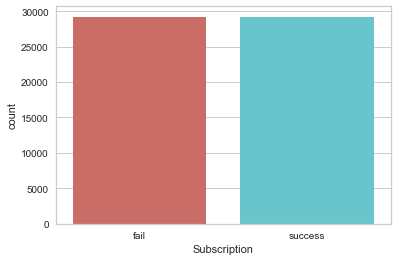

In [8]:
# print(bank_clean['target'].value_counts(normalize=True))
c=sns.countplot(x=os_data_y, palette='hls')#, data=bank_clean, palette='hls', )
plt.xlabel('Subscription')
c.set_xticklabels(['fail','success']);

plt.savefig('img/count_plot_SMOTE')

In [9]:
# Perform vanilla logistic regression
logreg_base_SMOTE = LogisticRegression(C = 1e9, solver='newton-cg')
logreg_base_SMOTE.fit(os_data_X, os_data_y)
y_hat_base_SMOTE = logreg_base_SMOTE.predict(os_data_X)

print(f"score = {np.round(logreg_base_SMOTE.score(os_data_X, os_data_y),3)}")
logistic_regression.print_metrics(os_data_y, y_hat_base_SMOTE)

score = 0.708
precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679


[0.754, 0.617, 0.754, 0.679]

The model score decreased again from 80% to 71%.<br>
However, the SMOTE method seems to increase all other metric scores. 

## Step 7.3: Using undersampling technique
This technique undersamples the majority class randomly

In [126]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train_scaled, y_train], axis=1)
X.head()
# separate minority and majority classes
success = X[X.target==1]
failure = X[X.target==0]
print(f"success original count: {len(success)}")
print(f"failure original count: {len(failure)}")

# downsample majority
failure_downsampled = resample(failure,
                               replace = False, # sample without replacement
                               n_samples = len(success), # match minority n
                               random_state = 19) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([failure_downsampled, success])

# checking counts
downsampled.target.value_counts()

success original count: 3711
failure original count: 29229


1    3711
0    3711
Name: target, dtype: int64

In [127]:
# Trying vanilla logistic regression again with the balanced dataset
y_train_undersample = downsampled['target']
X_train_undersample = downsampled.drop('target', axis=1)

downsampled_lr = LogisticRegression(C = 1e9, solver='newton-cg', max_iter=1000)
downsampled_lr.fit(X_train_undersample, y_train_undersample)

downsampled_pred = downsampled_lr.predict(X_train_undersample)

print(f"score = {np.round(downsampled_lr.score(X_train_undersample, y_train_undersample), 3)}")
logistic_regression.print_metrics(y_train_undersample, downsampled_pred)

score = 0.701
precision = 0.767
recall = 0.578
accuracy = 0.767
f1 score = 0.659


[0.767, 0.578, 0.767, 0.659]

The model score is slightly lower compared to SMOTE. <br>
The metric scores are about the same compared to SMOTE but SMOTE looks slightly better

##  Step 8: Recursive Feature Elimination (RFE)

In [128]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 10)
rfe = rfe.fit(os_data_X, os_data_y)
col_list = zip(os_data_X.columns, rfe.support_)
X_new_cols = [x[0] for x in col_list if x[1]==True]
# print(X_new_cols)
X_new = os_data_X[X_new_cols]
print(X_new.shape)
X_new.head()

(58458, 10)


,campaign,pdays,job_retired,default_unknown,contact_telephone,month_aug,month_jul,month_may,month_nov,poutcome_nonexistent
0,-0.564625,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,-0.459331,-0.709185,-0.333783,-2.511053
1,-0.204519,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,2.177080,-0.709185,-0.333783,0.398239
2,-0.564625,-0.19645,-0.209108,-0.515042,1.319514,-0.420234,2.177080,-0.709185,-0.333783,0.398239
3,0.155587,-0.19645,-0.209108,-0.515042,1.319514,-0.420234,-0.459331,-0.709185,-0.333783,0.398239
4,-0.564625,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,2.177080,-0.709185,-0.333783,0.398239


In [129]:
#Try applying new feature list into vanilla regression
rfe_lr = LogisticRegression(C = 1e9, solver='newton-cg', max_iter=1000)
rfe_lr.fit(X_new, os_data_y)
rfe_pred = rfe_lr.predict(X_new)

print(f"score = {np.round(rfe_lr.score(X_new, os_data_y), 3)}")
rfe_lst = logistic_regression.print_metrics(os_data_y, rfe_pred)

score = 0.694
precision = 0.745
recall = 0.591
accuracy = 0.745
f1 score = 0.659


## Step 9: Regularization and kFold Cross-Validation -- Using SMOTE'd data

don't run this, it will take time

In [131]:
# Vanilla 
vanilla_result, vanilla_lr, vanilla_cv = logistic_regression.cross_validation(n=5, shuffle=True,
                                                                             lr='vanilla',
                                                                             X_train=os_data_X,
                                                                             y_train=os_data_y)
# Ridge (l2)
l2_result, l2_reg, cv_l2 = logistic_regression.cross_validation(n=5, shuffle=True,
                                                                lr='l2',
                                                                X_train=os_data_X,
                                                                y_train=os_data_y)
# Lasso (l1)
l1_result, l1_reg, cv_l1 = logistic_regression.cross_validation(n=10, shuffle=True,
                                                                lr='l1',
                                                                X_train=os_data_X,
                                                                y_train=os_data_y)
# calculate the mean
print('Means:')
print('Vanilla regularization: ', vanilla_result.mean(axis=0))
print('l1 regularization: ', l1_result.mean(axis=0))
print('l2 regularixation: ', l2_result.mean(axis=0))

# calculate the std
print('------------------------------------')
print("Standard deviation")
print('Vanila regularization: ', vanilla_result.std(axis=0))
print('l1 regularization: ', l1_result.std(axis=0))
print('l2 regularixation: ', l2_result.std(axis=0))

Means:
Vanilla regularization:  [0.70812378 0.7077902 ]
l1 regularization:  [0.70825968 0.7074994 ]
l2 regularixation:  [0.70812378 0.7077902 ]
------------------------------------
Standard deviation
Vanila regularization:  [0.00064051 0.00233532]
l1 regularization:  [0.00045885 0.00288845]
l2 regularixation:  [0.00064051 0.00233532]


## Step 10: l2 Regularization -- Using SMOTE'd data

In [ ]:
# for i in [1e9, 1e2, 1, 1e-2, 1e-9]:
#     l1_reg = LogisticRegression(C=i, solver='saga', penalty='l1', max_iter=1000)
#     cv_l1 = cross_validate(estimator=l1_reg, X=os_data_X, y=y_train, cv=os_data_y, n_jobs=-1, return_estimator=True,
#                                return_train_score=True)
#     l1_result = np.concatenate((cv_l1['train_score'].reshape(-1, 1),
#                                 cv_l1['test_score'].reshape(-1, 1)), axis=1)

#     return l1_result, l1_reg, cv_l1

In [132]:
l1_mean_lst = []
l1_std_lst = []
for i in [1e9, 1e2, 1, 1e-2, 1e-9]:
    l1_result, l1_reg, cv_l1 = logistic_regression.cross_validation(n=5, shuffle=True, lr='l1',
                                                                    X_train=os_data_X,
                                                                    y_train=os_data_y,
                                                                    C = i)
    l1_mean_lst.append(l1_result.mean(axis=0))
    l1_std_lst.append(l1_result.std(axis=0))
#     print(f"C={i} result: {l1_result}")

In [133]:
y_std_plot = [x[0] for x in l1_std_lst]
y_mean_plot = [x[0] for x in l1_mean_lst]

In [ ]:
l2_mean_lst = []
l2_std_lst = []
for i in [1e9, 1e2, 1, 1e-2, 1e-9]:
    l2_result, l2_reg, cv_l2 = logistic_regression.cross_validation(n=5, shuffle=True, lr='l2',
                                                                    X_train=os_data_X,
                                                                    y_train=os_data_y,
                                                                    C = i)
    l2_mean_lst.append(l2_result.mean(axis=0))
    l2_std_lst.append(l2_result.std(axis=0))
#     print(f"C={i} result: {l2_result}") #, l1_reg, cv_l1 )

In [ ]:
y_l2_std_plot = [x[0] for x in l2_std_lst]
y_l2_mean_plot = [x[0] for x in l2_mean_lst]
print(y_l2_std_plot)
print(y_l2_mean_plot)

## Step 11: l2 Regularization with C=100

In [10]:
# from sklearn.linear_model import LogisticRegression
l2_reg = LogisticRegression(C=100, solver='newton-cg', max_iter=1000)
l2_reg.fit(X=os_data_X, y=os_data_y)
l2_reg_pred = l2_reg.predict(os_data_X)
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true=os_data_y,
                                            y_pred=l2_reg_pred),
                           index= ['actual 0', 'actual 1'],
                           columns= ['predicted 0', 'predicted 1']) 
logistic_regression.print_metrics(y_train=os_data_y, y_hat=l2_reg_pred)
conf_matrix

precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679


,predicted 0,predicted 1
actual 0,23358,5871
actual 1,11188,18041


precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679
None


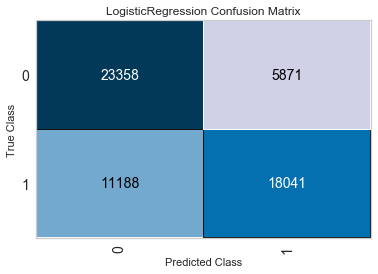

In [17]:
print(logistic_regression.print_metrics(y_train=os_data_y, y_hat=l2_reg_pred))
cm = ConfusionMatrix(l2_reg, cmap='PuBu', fontsize=14)
cm.fit(os_data_X, os_data_y)
cm.score(os_data_X, os_data_y)
cm.show()

(0.07082007595196549, 0.4402819117999247, 0.67)


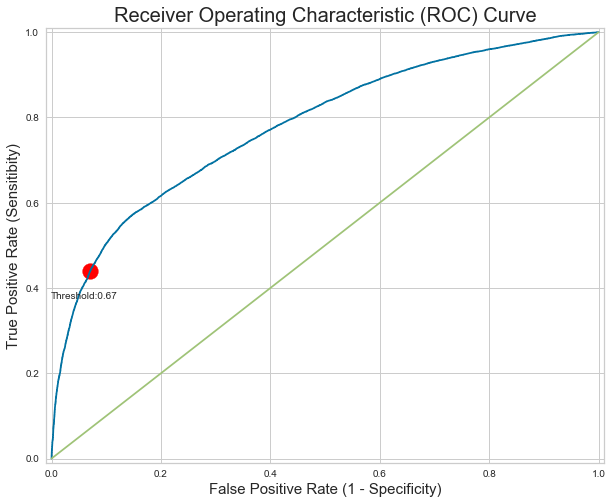

In [20]:
fpr, tpr, cost, thres = logistic_regression.minimize_cost(lr=l2_reg, X_train=os_data_X, y_train=os_data_y)
cost_idx = np.argmin(cost) # returns the minimum
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]
print(min_cost_threshold)

import logistic_regression_plots
logit_roc_auc = roc_auc_score(os_data_y, l2_reg.predict(os_data_X)) # area
fpr_lst, tpr_lst, thresholds = roc_curve(os_data_y, l2_reg.predict_proba(os_data_X)[:,1])
logistic_regression_plots.plot_threshold(min_cost_threshold,fpr=fpr_lst, tpr=tpr_lst )

precision = 0.861
recall = 0.44
accuracy = 0.861
f1 score = 0.583
None


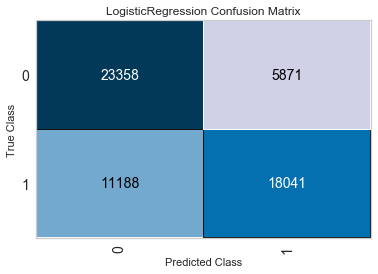

In [28]:
# working with 0.67 threshold
y_hat_thres = 1*(l2_reg.predict_proba(os_data_X)[:,1] >= 0.67)

print(logistic_regression.print_metrics(y_train=os_data_y, y_hat=y_hat_thres))

cm1 = ConfusionMatrix(l2_reg, cmap='PuBu', fontsize=14)
cm1.fit(os_data_X, os_data_y)
cm1.score(os_data_X, os_data_y)
cm1.show()

# cm = ConfusionMatrix(model, cmap='PuBu', fontsize=14)

# # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
# cm.fit(os_data_X, y_hat_thres)

# # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# # and then creates the confusion_matrix from scikit-learn.
# cm.score(os_data_X, y_hat_thres)

# How did we do?
# cm.show()

In [ ]:
precision = 0.861
recall = 0.44
accuracy = 0.861
f1 score = 0.583

In [111]:
x_list = []
y_list = []
lr = l2_reg

for x in np.linspace(0, 1, 100):
    
    # Same predictions based on predict_proba thresholds
    predicts = []
    
    for item in l2_reg.predict_proba(os_data_X):
        if item[0] <= x:
            predicts.append(1)
        else:
            predicts.append(0)

    conf_matrix = pd.DataFrame(confusion_matrix(os_data_y, predicts), index = ['actual 0', 'actual 1'], 
                     columns = ['predicted 0', 'predicted 1'])
    
    
    # Assign TP, TN, FP, FN
    true_positives = conf_matrix['predicted 1'][1]
    true_negatives = conf_matrix['predicted 0'][0]
    false_positives = conf_matrix['predicted 1'][0]
    false_negatives = conf_matrix['predicted 0'][1]

    
    # Calculate Sensitivity and Specificity
    recall = true_positives / (true_positives + false_negatives)

    precision = true_positives / (true_positives + false_positives)
    
    
    # Append to lists to graph
    x_list.append((recall,x))

    y_list.append((precision,x))

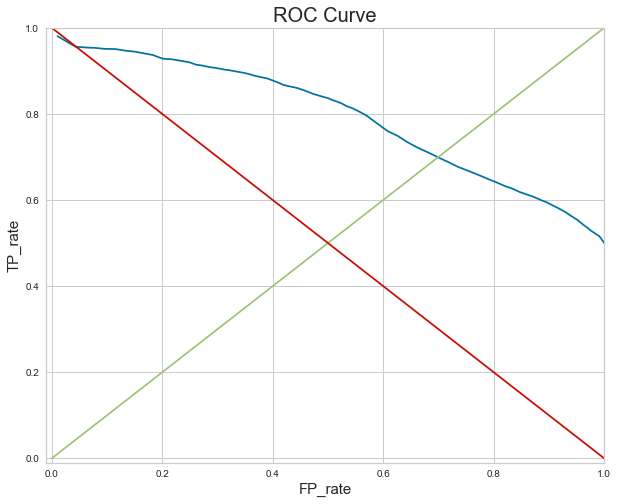

In [115]:

plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate', fontsize = 15)
plt.ylabel('TP_rate', fontsize = 15)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.plot(x_list, y_list);
plt.plot([1, 0], [0, 1]);

In [101]:
(l2_reg.predict_proba(os_data_X)[:,0]<0.5).sum()

23912

precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679

In [46]:
# 23358	5871
# actual 1	11188	18041
model = LogisticRegression()
model.fit(X=os_data_X, y=os_data_y)
y_test = model.predict(os_data_X)

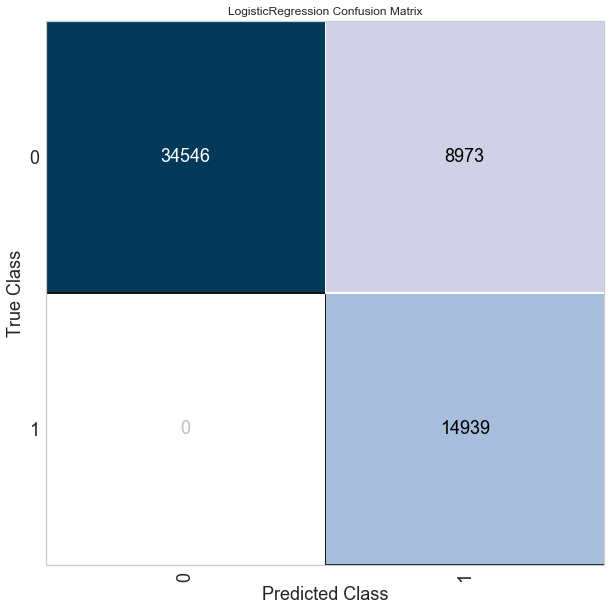

In [48]:
import logistic_regression_plots
logistic_regression_plots.nice_confusion(model, X_train=os_data_X, y_train=os_data_y,
                                        X_test=os_data_X, y_test=y_hat_thres)

In [106]:
l2_reg

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

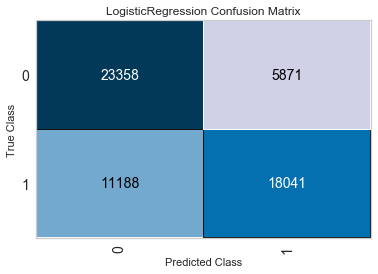

In [105]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, cmap='PuBu', fontsize=14)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(os_data_X, os_data_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(os_data_X, os_data_y)

# How did we do?
cm.show()

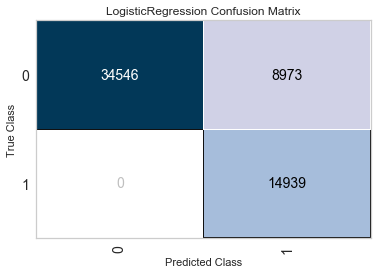

In [61]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, cmap='PuBu', fontsize=14)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(os_data_X, y_hat_thres)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(os_data_X, y_hat_thres)

# How did we do?
cm.show()

In [ ]:
# import logistic_regression_plots
# logistic_regression_plots.nice_confusion(l2_reg)

In [ ]:
fpr, tpr, cost, thres = logistic_regression.minimize_cost(lr=l2_reg, X_train=os_data_X, y_train=os_data_y)

In [ ]:
cost_idx = np.argmin(cost) # returns the minimum
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

print(min_cost_threshold)

In [ ]:
ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate (1 - specificity)', fontsize = 15)
plt.ylabel('TP_rate (sensitivity)', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))


In [ ]:
logistic_regression_plots.plot_threshold(min_cost_threshold, fpr=fpr, tpr=tpr)

In [ ]:
logit_roc_auc = roc_auc_score(y_test, model_RF_dummy_under.predict(X_test_LabelEncoder))
#fpr = false positive, #tpr = true positive
fpr, tpr, thresholds = roc_curve(y_test, model_RF_dummy_under.predict_proba(X_test_LabelEncoder)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
1*(l2_reg.predict_proba(os_data_X)[:,1] >= 0.5)

In [ ]:
y_hat_new = 1*(l2_reg.predict_proba(os_data_X)[:,1] >= 0.67)

In [ ]:
l2_reg.predict(os_data_X)

In [ ]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(y_true=os_data_y, y_pred=l2_reg_pred)

conf_matrix = pd.DataFrame(confusion_matrix(os_data_y,y_hat_new),
                                   index= ['actual 0', 'actual 1'],
                                  columns= ['predicted 0', 'predicted 1']) 
conf_matrix

In [ ]:
23358	5871
actual 1	11188	18041

## logit 

In [ ]:
X_col = X_train.columns
X_df = pd.DataFrame(data=os_data_X, columns=X_col)
y_df = pd.DataFrame(data=os_data_y, columns=['Sub'])

# os_data_X_df.head()
print(type(X_df))
print(type(y_df))


In [ ]:
data_y = os_data_y.reshape(-1,1)
data_y.shape

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(X_df[X_col], data_y).fit()
# result = logit_model.fit()
print(logit_model.summary2())
# result.summary()

# Create, fit model
#     mod = sm.Logit(endog=y_train, exog=X_train)
#     res = mod.fit(method='bfgs', maxiter=100)

#### SM model

In [ ]:
import statsmodels.api as sm
logit_model = sm.Logit(os_data_y, X_new)
result = logit_model.fit()
print(result.summary())

### Cross validation

In [ ]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg_vanilla = LogisticRegression(C=1e9, solver='newton-cg')
logreg_vanilla.fit(os_data_X, os_data_y)
y_hat_vanilla = logreg_vanilla.predict(X=os_data_X)


In [ ]:
print_metrics(os_data_y, y_hat_vanilla)

#### For vanilla

In [ ]:
# import logistic_regression as lr
# vanilla_result = lr.cross_validation(n=10, shuffle=True, lr='vanilla', X_train=os_data_X, y_train=os_data_y)
# vanilla_result

#### For l2

In [ ]:
# l2_result = lr.cross_validation(n=10, shuffle=True, lr='l2', X_train=os_data_X, y_train=os_data_y)
# l2_result

In [ ]:
l2_reg = LogisticRegression(C=1, solver='newton-cg', class_weight='balanced', max_iter=1000)
l2_reg.fit(os_data_X, os_data_y)
l2_reg_prd = l2_reg.predict(os_data_X)
print_metrics(os_data_y, l2_reg_prd,lr_reg=l2_reg)

#### For l1

In [ ]:
l1_reg = LogisticRegression(C=1, solver='saga',penalty='l1', max_iter=1000)
l1_reg.fit(os_data_X, os_data_y)
l1_reg_prd = l1_reg.predict(os_data_X)
print_metrics(os_data_y, l1_reg_prd, lr_reg=l1_reg)

In [ ]:
l1_result = lr.cross_validation(n=10, shuffle=True, lr='l1', X_train=os_data_X, y_train=os_data_y)
l1_result

In [ ]:
# calculate the mean
print('vanilla regularization', vanilla_result.mean(axis=0))
print('l1 regularization', l1_result.mean(axis=0))
print('l2 regularixation', l2_result.mean(axis=0))

In [ ]:
# calculate the std
print('vanilla regularization', vanilla_result.std(axis=0))
print('l1 regularization', l1_result.std(axis=0))
print('l2 regularixation', l2_result.std(axis=0))

In [ ]:
y_hat_df = pd.DataFrame(data=y_hat, columns=['y_hat'])
y_hat_df.y_hat.value_counts(normalize=True)

In [ ]:
true_posetive = np.count_nonzero(y_hat)
accuracy = true_posetive/len(y_hat)
print('accuracy', accuracy)
print('values', len(y_hat))


## Step 4: Modify data for Machine Learning

In [ ]:
X_train.head()

In [ ]:
bank_clean.columns

In [ ]:
dummed_train = pd.get_dummies(X_train, 
               columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'season', 'day_of_week', 'poutcome'], 
               drop_first= True)

In [ ]:
dummed_train.head()
print(dummed_train.shape)
print(dummed_train.columns)

In [ ]:
# calculate for age
mu, std = dummed_train.age.mean(), dummed_train.age.std()
print('mean age', mu, 'age std', std)
print('Standardized value for the first row is:', (dummed_train.age[1233]-mu)/std)
print(dummed_train.age[1233])
dummed_train.head()

## Step 7: Logistic Regression

In [ ]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg = LogisticRegression(class_weight='balanced', solver='newton-cg')
logreg.fit(dummed_train, y_train)

In [ ]:
print(logreg.score(dummed_train, y_train))

In [ ]:

#Standard Scaler to be used within pipelines.  
class StScaler(StandardScaler):
    def fit_transform(slf,X,y=None):
        print(f"transformed rows: {len(X)}")
        return super().fit_transform(X,y)

#Using pipeline to avoid data leakage within CV process 
pipe = Pipeline([
    ('scaler', StScaler()),
    ('logreg', LogisticRegression(C = 1e9, 
                                 solver = 'newton-cg',
                                 max_iter = 1000,
                                 class_weight = 'balanced'))
])

print(f"train data length: {len(dummed_train)} rows")
print(cross_val_score(pipe,dummed_train,y_train, cv=5))

## Step 8: Parameter Tuning

In [ ]:
#GridSearchCV for parameter tuning

# param_grid = {''}

# search = GridSearchCV(estimator=pipe,
#                       cv=5,
#                       param_grid=
#                       return_train_score=True)

# search.fit(X_train, y_train)
